<a href="https://colab.research.google.com/github/compi1234/spchlab/blob/master/session3/hillenbrand-2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Basic Machine Learning using using scikit-learn with the Hillenbrand database

### PART II:  RECOGNIZE a VOWEL FROM FORMANT MEASUREMENTS

### 1. Setting up your Python Environment
 
1. Import Python's Machine Learning Stack

2. Import needed local utilities that are needed for this exercise

In [1]:
# Importing Python's baseline machine learning stack 
#
% matplotlib inline
import sys,os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import scipy.io as sio

# imports from the scikit-learn 
from sklearn.datasets.base import Bunch
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import Perceptron
from sklearn import metrics as skmetrics
from sklearn.mixture import GaussianMixture

# Import and Install the LOCAL PACKAGE 'spchutils'
# set the variable 'ENVIRONMENT'  to: 
# - COLAB   when running this in the COLAB environment
# - LOCAL   for developer mode
#
#ENVIRONMENT = "COLAB"
ENVIRONMENT = "LOCAL"
if(ENVIRONMENT == "COLAB"):
    ! pip install git+https://github.com/compi1234/spchlab.git
elif(ENVIRONMENT == "LOCAL"):
    package_dir = 'C:\\Users\\compi\\Nextcloud\\GitHub\\spchlab'        
    os.chdir(package_dir)

from spchutils.hildata import fetch_hillenbrand

### 2. The Database 
All experiments in this notebook are using (parts of) the Hillenbrand '95 database. For detailed information and references: http://homes.esat.kuleuven.be/~spchlab/datasets/hillenbrand/README.txt

In [96]:
# you can grap a  subset of 6 or 3 vowels by specifying 'vowels6' or 'vowels3', default is 'all'
# Hillenbrand dataset contains records with missing data
# we drop all records with missing (NA) variables with .dropna()
hildata = fetch_hillenbrand(genders='adults',vowels='all',columns=["vid","f0","F1","F2","F3"]).dropna()
hildata.rename(columns={'vid':'vowel'},inplace=True)

print(hildata.head())
#print(hildata.columns, hildata.index)

  vowel     f0     F1      F2      F3
0    ae  174.0  663.0  2012.0  2659.0
1    ae  102.0  628.0  1871.0  2477.0
2    ae   99.0  605.0  1812.0  2570.0
3    ae  124.0  627.0  1910.0  2488.0
4    ae  115.0  647.0  1864.0  2561.0


### 3. Data Exploration

In this task we have multiple features that can be used to make our classififier better.
First task is to decide which ones to use.

Scatter plots may give us an insight as to which features are most relevant.
We can make a simple scatter plot with 2 preselected features, or can have a conglomerate of scatter plots for a getter overview

##### Tasks & Questions (1)
1. What do the scatter plots tell you.  Are there features that must be retained or others that can surely be dropped ?

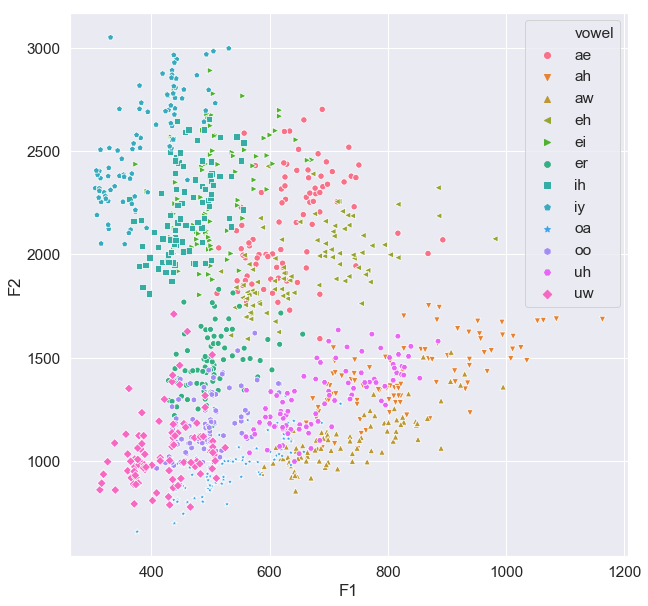

In [97]:
# a simple scatter plot with 2 selected features
# the categgories can be shown as hue(color) or style(marker)
f=plt.figure(figsize=(10,10))
# seaborn has only 6 markers defined, so we need to add more
my_markers = ('o', 'v', '^', '<', '>', '8', 's', 'p', '*', 'h', 'H', 'D', 'd', 'P', 'X')
sns.scatterplot(x='F1',y='F2',data=hildata,hue="vowel",style="vowel",markers=my_markers,s=40)

<Figure size 720x720 with 0 Axes>

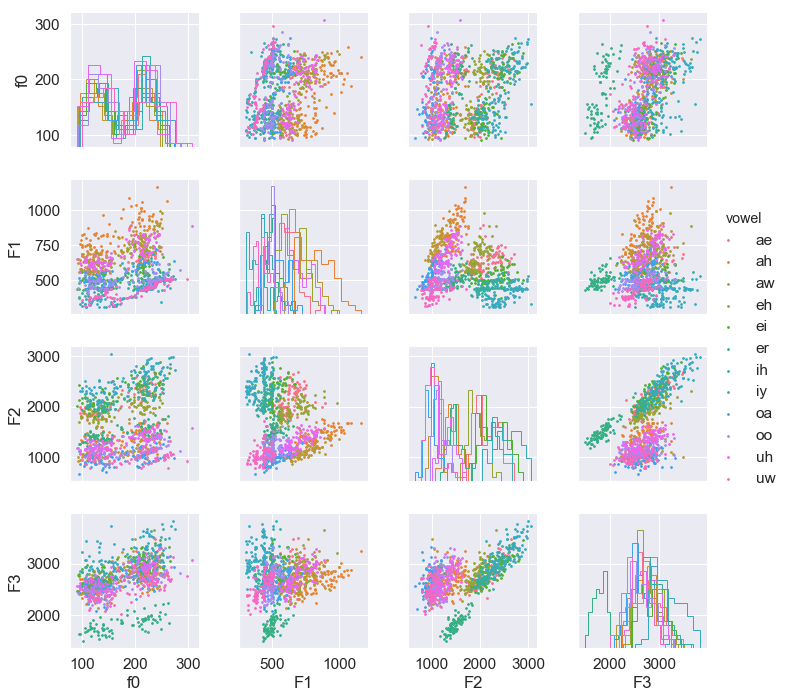

In [99]:
# if we want to see multiple scatter plots for the same data, we can first construct a grid over
# which we will make the plots
f=plt.figure(figsize=(10,10))
g = sns.PairGrid(hildata,hue="vowel")
g.map_diag(plt.hist,histtype="step", linewidth=1)
g.map_offdiag(plt.scatter,s=3)
g.add_legend()

In [103]:
# We will restrict ourselves to F1, F2 and F3 data in the classification experiments
X=np.array(hildata.loc[:,['F1','F2','F3']])
y=np.array(hildata.loc[:,'vowel'])
classes = np.unique(y)

### 4. Classification using a Bayesian classifier and Gaussian models

We know now enough to create and test our classifier
1. split the data in  training set and  test set
    -  X_train, y_train, X_test, y_test
2. train models in each class given the training data 
3. construct a classifier using the Bayesian rule and posteriors
4. evaluate on test data; look at overall score 
5. look more in detail to a confusion matrix (next codeblock)

For this, we will use the class *GaussianMixtureClass* which is provided in *spchutils* .
It is implemented as an extension to *sklearn*, making use of the sklearn GaussianMixture density estimator, as we used before. 

There are a number of parameters that you may adjust in the following code blocks
- n_components:  the number of mixtures used in the Gaussian MM
- train_size:    the proportion of the data that will be used for training, the remainder is used for testing
- priors_test:   
- random_state:  you can modify this to have a different division between train and test sets and see if you get different results


##### Task & Questions (3)
1. Evaluate the performance for different settings in n_components (number of gaussians) 1,2,4,8 . Is there a need to change max_iter, the maximum number of iterations for EM
2. Evaluate the performance for different feature sets, [F1,F2] vs. [F1,F2,F3]
3. (optional) Go back and use a smaller database, just selecting the short vowels with 'vowels6' and do the same analysis

In [111]:
from spchutils.GaussianMixtureClf import GaussianMixtureClf
# --------------
n_components = 8
train_size=0.5
max_iter = 10      # maximum number of iterations in the EM algorithm
random_state=0     # sets initialization of RNG for selecting train/test data, set to None to be random
priors_test = None # should be None or a vector of type e.g. [0.8 , 0.2] expects 80% male
# --------------
# 1. select non-overlapping train and test sets
test_size=1.0 - train_size
X_train, X_test, y_train, y_test =  train_test_split(X,y,test_size=test_size, random_state=random_state)
clf_GM = GaussianMixtureClf(classes=classes,n_components=n_components,max_iter=max_iter)
clf_GM.fit(X_train,y_train)
# 2. print the model
clf_GM.print()
#print("Classes: ",clGM.classes_)
y_pred = clf_GM.predict(X_test,priors=priors_test)
print('Accuracy: %.2f%%' % (100.0*skmetrics.accuracy_score(y_test, y_pred)))

Class[0] (ae) with prior=0.077
-----------------------------------
[0.09389766 0.33148222 0.07142512 0.19157986 0.04744157 0.11957717
 0.04762551 0.09697089] [[ 712.15145028 2364.84109127 2933.59601883]
 [ 577.45651372 1934.97731395 2550.53491511]
 [ 580.40888189 2165.06597759 3029.21554138]
 [ 667.15265257 2245.54917486 2764.75076864]
 [ 649.63357274 1679.67979973 2350.34710211]
 [ 678.19799877 2482.05958949 3165.12587862]
 [ 819.43130453 2007.0300317  2975.49205804]
 [ 634.73113578 1971.92568444 2696.00213724]] [[27.86638593 47.9958419  38.04864253]
 [35.60746725 74.166438   48.41188986]
 [45.88210236 46.88739177 77.78640708]
 [64.74406585 83.97665614 59.05282003]
 [35.49916808 88.01569178 42.51272624]
 [39.01273262 71.44121627 86.64216518]
 [73.62685377 63.01354234 48.5301686 ]
 [28.03505845 30.62605015 90.11480918]]
Class[1] (ah) with prior=0.090
-----------------------------------
[0.09143175 0.16154905 0.16475991 0.02040816 0.0815577  0.22168643
 0.23819882 0.02040816] [[ 761.863

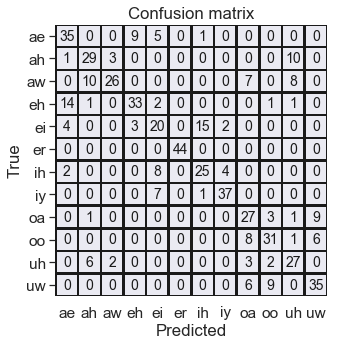

Accuracy: 67.71%


In [112]:
# A Confusion Matrix gives a more detailed image of the errors that we make
# The routine makes for pretty printing
def plot_confusion_matrix(cm,labels=[],cmap=[]):
    import seaborn as sns

    if len(labels) == 0:
        df_cm = pd.DataFrame(cm)
    else:
        df_cm = pd.DataFrame(cm, labels, labels)
        
    f,ax = plt.subplots(figsize=(5,5))
    sns.set(font_scale=1.4)#for label size
    sns.heatmap(df_cm, annot=True,fmt="d",annot_kws={"fontsize": 14,"color":'k'},
                square=True,linecolor='k',linewidth=1.5,cmap=cmap,cbar=False)
    ax.tick_params(axis='y',labelrotation=0.0,left=True)
    # font size
    plt.title('Confusion matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

y_pred = clf_GM.predict(X_test)
cmat = skmetrics.confusion_matrix(y_test,y_pred)
#print('Confusion Matrix:\n',cmat)    
    
plot_confusion_matrix(cmat,labels=classes)
print('Accuracy: %.2f%%' % (100.0*skmetrics.accuracy_score(y_test, y_pred)))

In [114]:
# Instead of using a single fixed split between train and test
# we often prefer to evaluate using a cross validation procedure
# For this we split the full data randomly in Nfolds of roughly equal size
# Then we take each of the folds as test_set and train on all remaining folds
# Finally we average the results
# This procedure is especially useful for small datasets.
# For this problem the dataset is big enough and a simple train/test split did the job
nfolds = 10
clf_GM = GaussianMixtureClf(classes=classes,n_components=4,max_iter=40)
scores = cross_val_score(clf_GM, X, y, cv=nfolds)
print("Average Cross validation score for %d folds: %.2f %% correct" % (nfolds,100.0*np.average(scores)))

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\mixture\base.py:237: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)


Average Cross validation score for 10 folds: 75.18 % correct


ValueError: Expected the input data X have 3 features, but got 1 features

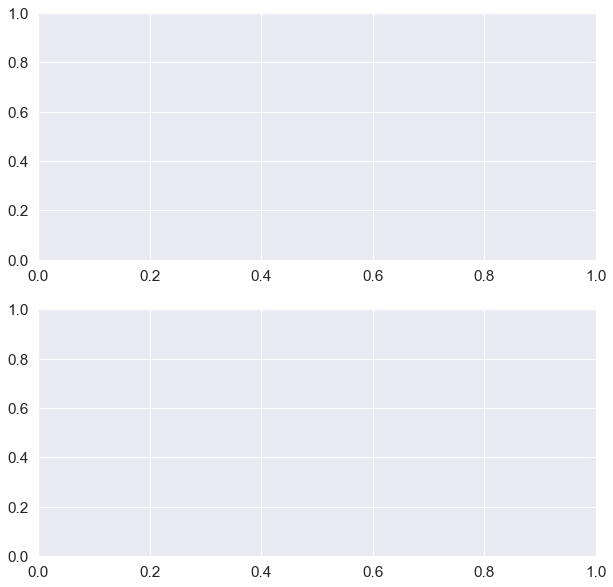

In [71]:
# have a look at the internals of the classifier
# by looking at likelihoods per class and 
# predicted probabilities per class over the whole pitch range
x = np.vstack(np.linspace(50.,400.,100))
fig,ax = plt.subplots(2,1,figsize=(10,10))

# 1. likelihoods
z = clf_GM.predict_prob(x)
h = ax[0].plot(x,z)
ax[0].set_xlabel("Freq (Hz)")
ax[0].set_ylabel("p(f0|class)")
ax[0].legend(class_names,loc='upper right')
ax[0].grid(True)
# 2. posteriors
z = clf_GM.predict_proba(x)
h = ax[1].plot(x,z)
ax[1].set_xlabel("Freq (Hz)")
ax[1].set_ylabel("P(class|f0)")
ax[1].legend(class_names,loc='upper right')
ax[1].grid(True)
ax[1].set_xticks(x,minor=True)
plt.show()

In [72]:
# Now test on some independent data
# 
my_test = np.array([89.,  173., 199., 240., 112., 288.]).reshape(-1,1)
priors=[.5,.5]
print(clf_GM.predict_proba(my_test,priors=priors))
print(clf_GM.predict(my_test,priors=priors))

ValueError: Dimensions of priors do not match number of classes